# EDA and statistical tests for the features of dataset for predictive modelling

In [ ]:
import pandas as pd

pd.set_option("display.max_columns", None)

customer_df = pd.read_csv("dataset\raw_dataset.csv")
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Analyzing `StreamingTV` and `StreamingMovies`

In [ ]:
customer_df['StreamingMovies'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
customer_df['StreamingTV'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
customer_df['StreamingTV'].value_counts(normalize=True)

,proportion
StreamingTV,
No,0.398978
Yes,0.384353
No internet service,0.216669


In [ ]:
customer_df['StreamingMovies'].value_counts(normalize=True)

,proportion
StreamingMovies,
No,0.395428
Yes,0.387903
No internet service,0.216669


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

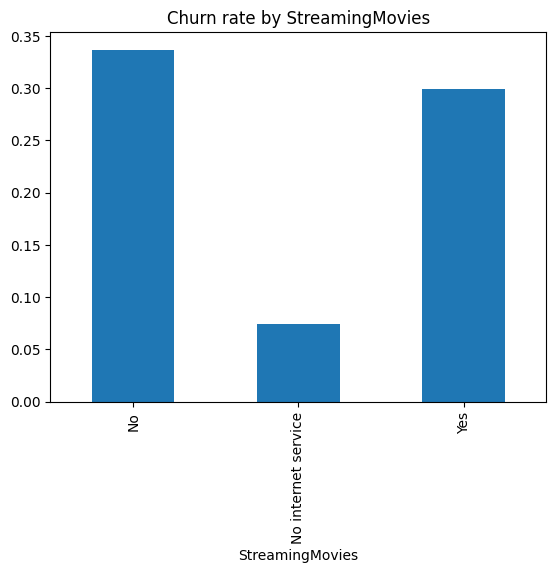

In [ ]:
movie_rate = customer_df.groupby('StreamingMovies')['Churn'].apply(lambda x: (x=='Yes').mean())
movie_rate.plot(kind='bar')
plt.title("Churn rate by StreamingMovies")
plt.show()

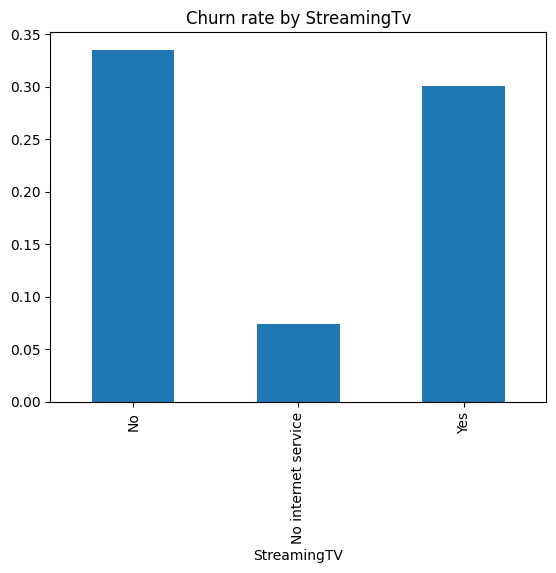

In [ ]:
tv_rate = customer_df.groupby('StreamingTV')['Churn'].apply(lambda x: (x=='Yes').mean())
tv_rate.plot(kind='bar')
plt.title("Churn rate by StreamingTv")
plt.show()

## Chi2 for StreamingMovies

In [ ]:
ct_movies = pd.crosstab(customer_df['StreamingMovies'], customer_df['Churn'], margins=True)
ct_movies

Churn,No,Yes,All
StreamingMovies,,,
No,1847,938,2785
No internet service,1413,113,1526
Yes,1914,818,2732
All,5174,1869,7043


In [ ]:
from scipy.stats import chi2_contingency

chi2_mv, p_mv, dof_mv, expected_mv = chi2_contingency(ct_movies.iloc[:-1, :-1])
print("Chi2 statistics for Movies:", chi2_mv)
print("P value for movies:", p_mv)
print("Degrees of freedom:", dof_mv)
print("\nExpected contigency table (if independent):\n", np.round(expected_mv, 1))

Chi2 statistics for Movies: 375.6614793452656
P value for movies: 2.667756755723681e-82
Degrees of freedom: 2

Expected contigency table (if independent):
 [[2045.9  739.1]
 [1121.   405. ]
 [2007.   725. ]]


In [ ]:
print("Reject null hypotheses of independent features as Churn and Streaming Movies:", p_mv < 0.05)

Reject null hypotheses of independent features as Churn and Streaming Movies: True


## Chi2 test for StreamingTv

In [ ]:
ct_tv = pd.crosstab(customer_df['StreamingTV'], customer_df['Churn'], margins=True)
ct_tv

Churn,No,Yes,All
StreamingTV,,,
No,1868,942,2810
No internet service,1413,113,1526
Yes,1893,814,2707
All,5174,1869,7043


In [ ]:
chi2_tv, p_tv, dof_tv, expected_tv = chi2_contingency(ct_tv.iloc[:-1, :-1])
print("Chi2 statistics for Movies:", chi2_tv)
print("P value for movies:", p_tv)
print("Degrees of freedom:", dof_tv)
print("\nExpected contigency table (if independent):\n", np.round(expected_tv, 1))

Chi2 statistics for Movies: 374.2039433109813
P value for movies: 5.528994485739183e-82
Degrees of freedom: 2

Expected contigency table (if independent):
 [[2064.3  745.7]
 [1121.   405. ]
 [1988.6  718.4]]


In [ ]:
print("Reject null hypotheses of independent features as Churn and Streaming TV:", p_tv < 0.05)

Reject null hypotheses of independent features as Churn and Streaming TV: True


### Cramer's V for effect strength

In [ ]:
def cramers_V(chi2, n, r, c):
  return np.sqrt(chi2/ (n * min(r-1, c-1)))

In [ ]:
n_v = ct_movies.iloc[:-1, :-1].to_numpy().sum()
r_mv, c_mv = ct_movies.iloc[:-1, :-1].shape

mv_V = cramers_V(chi2_mv, n_v, r_mv, c_mv)
print("Cramer's V for Churn and StreamingMovies:", mv_V)

Cramer's V for Churn and StreamingMovies: 0.23095080906926801


In [ ]:
n_tv = ct_tv.iloc[:-1, :-1].to_numpy().sum()
r_tv, c_tv = ct_tv.iloc[:-1, :-1].shape

tv_V = cramers_V(chi2_tv, n_tv, r_tv, c_tv)
print("Cramer's V for Churn vs StreamingTV:", tv_V)

Cramer's V for Churn vs StreamingTV: 0.2305023384466809


In [ ]:
from sklearn.feature_selection import mutual_info_classif
X = pd.get_dummies(customer_df[['StreamingMovies', 'StreamingTV']], drop_first=True)
mic = mutual_info_classif(X, customer_df['Churn'].map({"No": 1, "Yes": 0}))
print("MIV StreamingMovies/Tv:", dict(zip(X.columns, mic)))

MIV StreamingMovies/Tv: {'StreamingMovies_No internet service': np.float64(0.03554053359549614), 'StreamingMovies_Yes': np.float64(0.0), 'StreamingTV_No internet service': np.float64(0.03146981319140041), 'StreamingTV_Yes': np.float64(0.0006694176106145644)}


In [ ]:
ct_combined = pd.crosstab(customer_df['StreamingMovies'], customer_df['StreamingTV'])
ct_combined

StreamingTV,No,No internet service,Yes
StreamingMovies,,,
No,2018,0,767
No internet service,0,1526,0
Yes,792,0,1940


In [ ]:
corelation_stream = X.corr()
corelation_stream

,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No internet service,StreamingTV_Yes
StreamingMovies_No internet service,1.000000,-0.418675,1.000000,-0.415552
StreamingMovies_Yes,-0.418675,1.000000,-0.418675,0.533094
StreamingTV_No internet service,1.000000,-0.418675,1.000000,-0.415552
StreamingTV_Yes,-0.415552,0.533094,-0.415552,1.000000


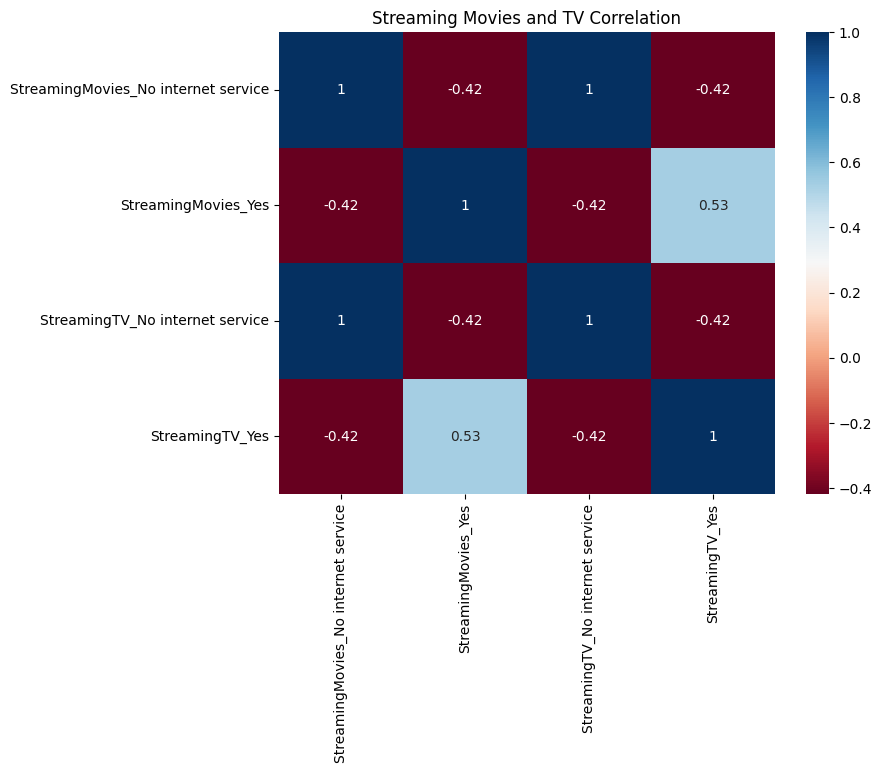

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(data=corelation_stream, annot=True, cmap='RdBu')
plt.title("Streaming Movies and TV Correlation")
plt.show()

The Chi2 test it shows the feature Streaming Tv and Streaming Movies are dependent to churn. The Cramer's V test points the strength of association. But when looking on, the two features are the almost same. When taking correlation, it is clear that the No InternetService is reduntant. The Yes category has moderately correlated but not identical. From mutual information classifier, the Yes and No is almost 0, while the No internet Service is slightly up. This may be because the group with No internet Service will have only TV plans or small plans which will the chance of low churn. because So keeping the features as for Tree models and later when taking Logistic Regression, it can be dropped or combined.

## Taking the next feature `TechSupport` and `OnlineSecurity`

In [ ]:
customer_df['TechSupport'].value_counts(normalize=True)

,proportion
TechSupport,
No,0.493114
Yes,0.290217
No internet service,0.216669


In [ ]:
customer_df['TechSupport'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
customer_df['OnlineSecurity'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

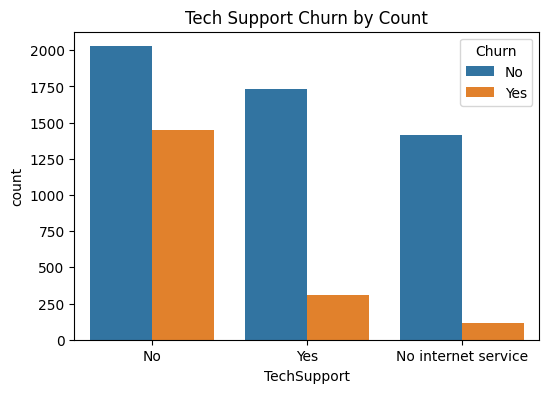

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='TechSupport', hue='Churn')
plt.title("Tech Support Churn by Count")
plt.show()

In [ ]:
tech_rate = customer_df.groupby('TechSupport')['Churn'].apply(lambda x: (x=='Yes').mean())
tech_rate

,Churn
TechSupport,
No,0.416355
No internet service,0.074050
Yes,0.151663


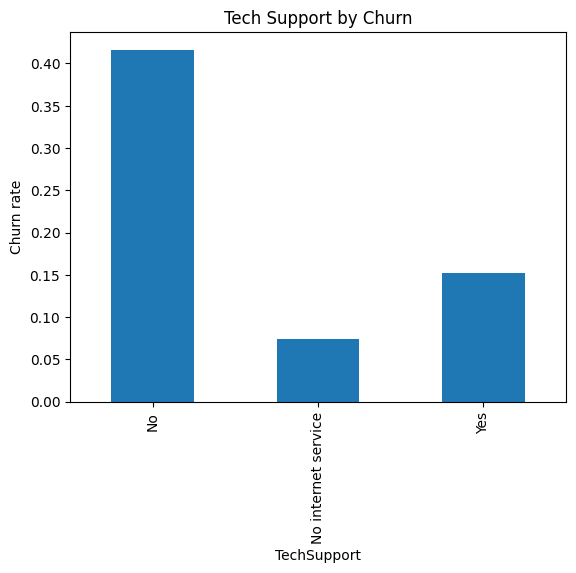

In [ ]:
tech_rate.plot(kind='bar')
plt.title("Tech Support by Churn")
plt.ylabel("Churn rate")
plt.show()

## Chi2 test

Null hypotheses h0: The techsupport is independent of Churn

Alternative hypotheses h1: It is not independent of Churn

In [ ]:
ct_tech = pd.crosstab(customer_df['TechSupport'], customer_df['Churn'], margins=True)
ct_tech

Churn,No,Yes,All
TechSupport,,,
No,2027,1446,3473
No internet service,1413,113,1526
Yes,1734,310,2044
All,5174,1869,7043


In [ ]:
chi2_tech, p_tech, dof_tech, expected_tech = chi2_contingency(ct_tech.iloc[:-1, :-1])
print("Chi2 statistics for Tech support:", chi2_tech)
print("P Value Tech support:", p_tech)
print("Degrees of freedom for Tech support:", dof_tech)
print("\nExpected contigency table (if independent) for Tech support:\n", expected_tech)

Chi2 statistics for Tech support: 828.1970684587394
P Value Tech support: 1.4430840279998987e-180
Degrees of freedom for Tech support: 2

Expected contigency table (if independent) for Tech support:
 [[2551.37043873  921.62956127]
 [1121.04557717  404.95442283]
 [1501.5839841   542.4160159 ]]


In [ ]:
print("Rejecting null hypotheses that Tech Support is independent of Churn:", p_tech < 0.05)

Rejecting null hypotheses that Tech Support is independent of Churn: True


In [ ]:
n_tech = ct_tech.iloc[:-1, :-1].to_numpy().sum()
r_tech, c_tech = ct_tech.iloc[:-1, :-1].shape
Tech_V = cramers_V(chi2_tech, n_tech,
                   r_tech, c_tech)
print("The strength of association:", Tech_V)

The strength of association: 0.3429161982469257


### Residuals

In [ ]:
def pearson_res(observed, expected):

  residual = (observed - expected) / np.sqrt(expected)
  return residual

In [ ]:
def haberman_res(observed, expected,
                 row_total, col_total, N):
  adj_denom = np.sqrt(expected * (1 - (row_total/N)) * (1- (col_total/N)))
  std_res = (observed - expected) / adj_denom

  return std_res

In [ ]:
ct_tech.iloc[:-1, :-1]

Churn,No,Yes
TechSupport,,
No,2027,1446
No internet service,1413,113
Yes,1734,310


In [ ]:
raw_residuals = ct_tech.iloc[:-1, :-1].to_numpy() - expected_tech
raw_residuals

array([[-524.37043873,  524.37043873],
       [ 291.95442283, -291.95442283],
       [ 232.4160159 , -232.4160159 ]])

In [ ]:
obs_tech = ct_tech.iloc[:-1, :-1].to_numpy()

pearson_res_tech = pearson_res(obs_tech, expected_tech)
print("Pearson Residuals:", pearson_res_tech)

Pearson Residuals: [[-10.38129281  17.27269094]
 [  8.71973776 -14.50814828]
 [  5.99778976  -9.9792936 ]]


In [ ]:
row_total_tech = obs_tech.sum(axis=1)[:, None]
col_total_tech = obs_tech.sum(axis=0)[None, :]
N_tech = obs_tech.sum()

std_res_tech = haberman_res(obs_tech, expected_tech,
                            row_total_tech, col_total_tech,
                            N_tech)
print("Standard Residuals:\n", std_res_tech)

Standard Residuals:
 [[-28.30546999  28.30546999]
 [ 19.12515527 -19.12515527]
 [ 13.81983022 -13.81983022]]


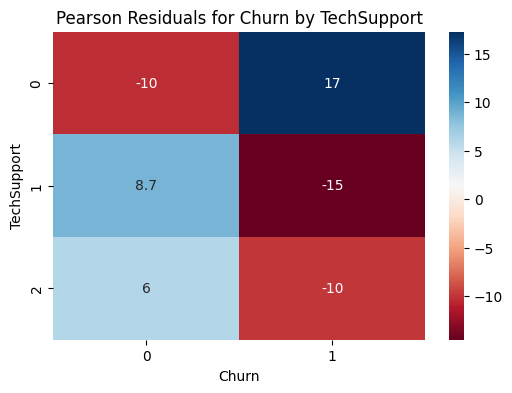

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_res_tech, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("TechSupport")
plt.title("Pearson Residuals for Churn by TechSupport")
plt.show()

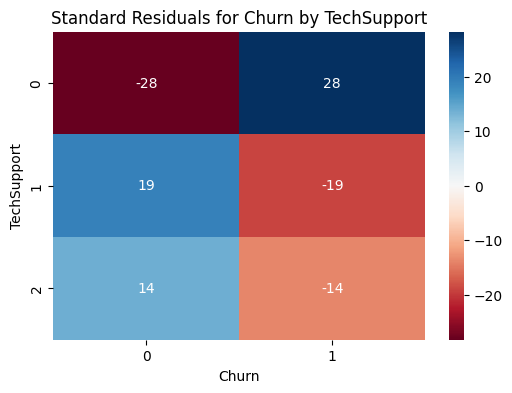

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_res_tech, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("TechSupport")
plt.title("Standard Residuals for Churn by TechSupport")
plt.show()

### CI Wilson

In [ ]:
ct_tech['Churn rate'] = ct_tech['Yes'] / ct_tech['All']
ct_tech

Churn,No,Yes,All,Churn rate
TechSupport,,,,
No,2027,1446,3473,0.416355
No internet service,1413,113,1526,0.074050
Yes,1734,310,2044,0.151663
All,5174,1869,7043,0.265370


In [ ]:
from statsmodels.stats.proportion import proportion_confint

CI_tech = ct_tech.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                    axis=1)

ct_tech['CI Low'] = [c[0] for c in CI_tech]
ct_tech['CI High'] = [c[1] for c in CI_tech]

ct_tech

Churn,No,Yes,All,Churn rate,CI Low,CI High
TechSupport,,,,,,
No,2027,1446,3473,0.416355,0.400061,0.432833
No internet service,1413,113,1526,0.074050,0.061954,0.088284
Yes,1734,310,2044,0.151663,0.136768,0.167866
All,5174,1869,7043,0.265370,0.255188,0.275807


In [ ]:
ct_tech.iloc[:-1]

Churn,No,Yes,All,Churn rate,CI Low,CI High
TechSupport,,,,,,
No,2027,1446,3473,0.416355,0.400061,0.432833
No internet service,1413,113,1526,0.074050,0.061954,0.088284
Yes,1734,310,2044,0.151663,0.136768,0.167866


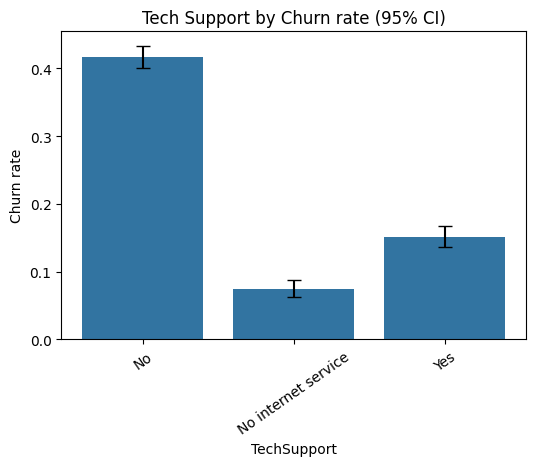

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_tech[:-1].index, y=ct_tech['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_tech[:-1])), y=ct_tech['Churn rate'][:-1],
             yerr=[ct_tech['Churn rate'][:-1] - ct_tech['CI Low'][:-1], ct_tech['CI High'][:-1] - ct_tech['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.xticks(rotation=35)
plt.title("Tech Support by Churn rate (95% CI)")
plt.show()

In [ ]:
obs_tech[2]

array([1734,  310])

In [ ]:
yes_vs_no = np.vstack([obs_tech[0], obs_tech[2]])
yes_vs_noint = np.vstack([obs_tech[1], obs_tech[2]])

In [ ]:
import statsmodels.api as sm

table_yn = sm.stats.Table2x2(yes_vs_no)
odds_ratio_tech_yn = table_yn.oddsratio
odds_ratio_tech_yn_ci =table_yn.oddsratio_confint()

print("OddsRatio for Yes and No techsupport:", odds_ratio_tech_yn)
print("95% CI:", odds_ratio_tech_yn_ci)


OddsRatio for Yes and No techsupport: 0.25060980376203856
95% CI: (np.float64(0.21821512057621995), np.float64(0.28781357394393003))


In [ ]:
table_yint = sm.stats.Table2x2(yes_vs_noint)
odds_ratio_tech_yint = table_yint.oddsratio
odds_ratio_tech_yint_ci = table_yint.oddsratio_confint()
print("OddsRatio for Yes and NoInterntService techsupport:", odds_ratio_tech_yint)
print("95% CI:", odds_ratio_tech_yint_ci)


OddsRatio for Yes and NoInterntService techsupport: 2.2355084667911935
95% CI: (np.float64(1.7823402075751253), np.float64(2.8038968564223863))


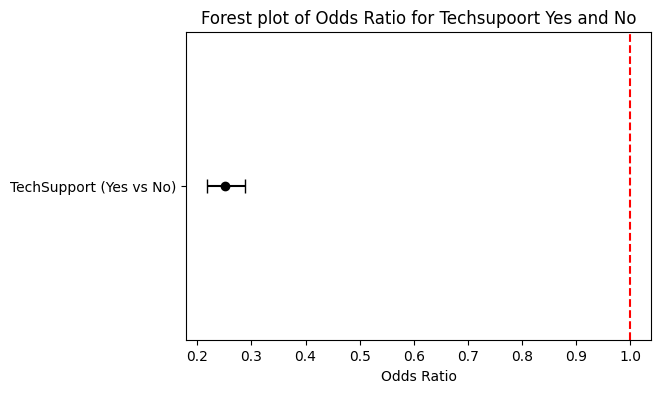

In [ ]:
features = ['TechSupport (Yes vs No)']
ci_low_tech = odds_ratio_tech_yn_ci[0]
ci_high_tech = odds_ratio_tech_yn_ci[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_tech_yn], features,
            xerr=[[odds_ratio_tech_yn - ci_low_tech], [ci_high_tech- odds_ratio_tech_yn]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for Techsupoort Yes and No")

plt.show()

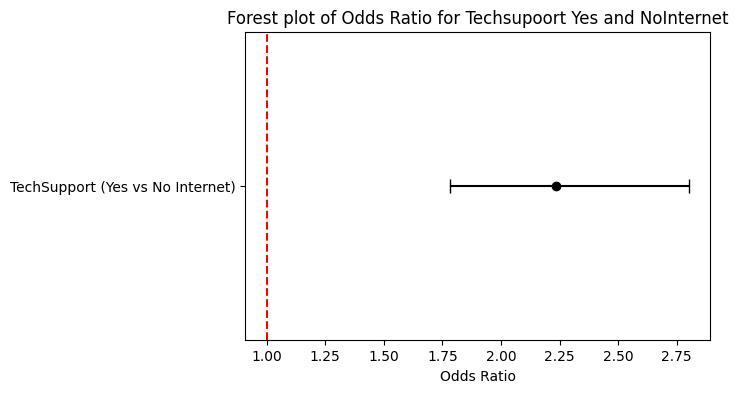

In [ ]:
features = ['TechSupport (Yes vs No Internet)']
ci_low_tech = odds_ratio_tech_yint_ci[0]
ci_high_tech = odds_ratio_tech_yint_ci[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_tech_yint], features,
            xerr=[[odds_ratio_tech_yint - ci_low_tech], [ci_high_tech - odds_ratio_tech_yint]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for Techsupoort Yes and NoInternet")

plt.show()

The estimation was is the techsupport a predictor for Churn. From the chi square test, the null hypotheses for independent features was rejected. WHen took Cramer's V for the association, it was 0.34 which was a moderate but stronger predictor. From wilson CI, the CIs doesn't overlapped which shows the distinguishability amongthe categories. The oddsratio tells the story among the group that the group with techsupport is less likely to churn than without tech support by 75% lower for yes. While the group without internet service is having 2 x lower odds compared to having tech support.

Insight: The No internet service group have very small churning because as they don't have internet so techsupport is not needed. The customers which don't use internet comes under it. The business focus should be to the group without tech support. When increasing tech support, the analysis shows that it can reduce more churners

`OnlineSecurity`

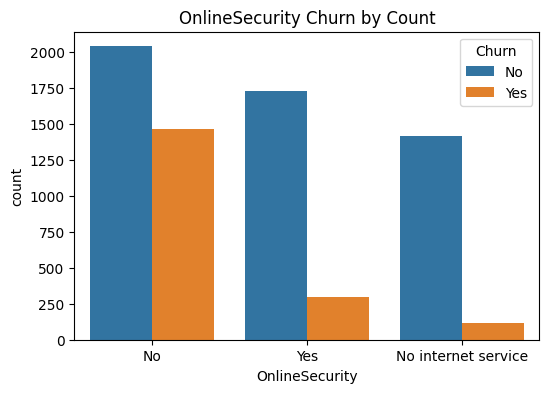

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='OnlineSecurity', hue='Churn')
plt.title("OnlineSecurity Churn by Count")
plt.show()

In [ ]:
sec_rate = customer_df.groupby('OnlineSecurity')['Churn'].apply(lambda x: (x=='Yes').mean())
sec_rate

,Churn
OnlineSecurity,
No,0.417667
No internet service,0.074050
Yes,0.146112


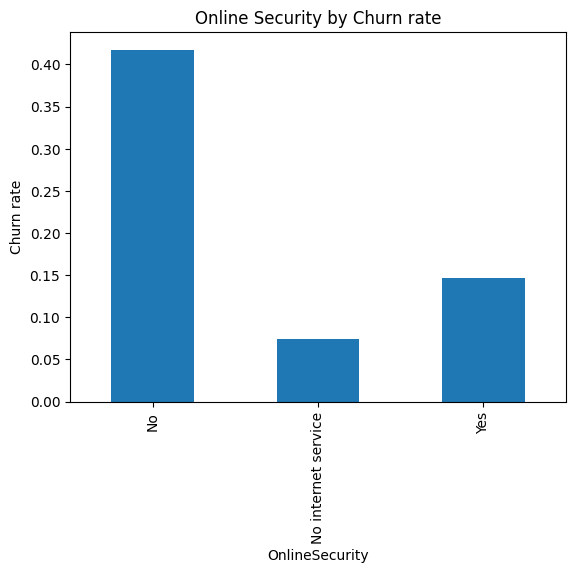

In [ ]:
sec_rate.plot(kind='bar')
plt.title("Online Security by Churn rate")
plt.ylabel("Churn rate")
plt.show()

### Chi2 test

Null hypotheses H0: The churn and onlinesecurity is independent

Alternative hypotheses H1: The Churn and OnlineSecurity is not independent

In [ ]:
ct_sec = pd.crosstab(customer_df['OnlineSecurity'], customer_df['Churn'], margins=True)
ct_sec

Churn,No,Yes,All
OnlineSecurity,,,
No,2037,1461,3498
No internet service,1413,113,1526
Yes,1724,295,2019
All,5174,1869,7043


In [ ]:
chi2_sec, p_sec, dof_sec, expected_sec = chi2_contingency(ct_sec.iloc[:-1, :-1])
print("Chi2 statistics for Tech support:", chi2_sec)
print("P Value Tech support:", p_sec)
print("Degrees of freedom for Tech support:", dof_sec)
print("\nExpected contigency table (if independent) for Tech support:\n", expected_sec)

Chi2 statistics for Tech support: 849.9989679615965
P Value Tech support: 2.661149635176552e-185
Degrees of freedom for Tech support: 2

Expected contigency table (if independent) for Tech support:
 [[2569.73619196  928.26380804]
 [1121.04557717  404.95442283]
 [1483.21823087  535.78176913]]


In [ ]:
print("Rejecting the null hypotheses:", p_sec < 0.05)

Rejecting the null hypotheses: True


In [ ]:
obs_sec = ct_sec.iloc[:-1, :-1].to_numpy()
N_sec = obs_sec.sum()
r_sec, c_sec = ct_sec.iloc[:-1, :-1].shape
sec_V = cramers_V(chi2_sec, N_sec,
                  r_sec, c_sec)

print("Cramer's V strength of association:", sec_V)

Cramer's V strength of association: 0.3474004326740552


In [ ]:
Tech_V

np.float64(0.3429161982469257)

### Residuals

In [ ]:
raw_residuals = obs_sec - expected_sec
raw_residuals

array([[-532.73619196,  532.73619196],
       [ 291.95442283, -291.95442283],
       [ 240.78176913, -240.78176913]])

In [ ]:
pearson_sec = pearson_res(obs_sec, expected_sec)
print("Pearson Residuals for OnlineSecurity:\n", np.round(pearson_sec,1))

Pearson Residuals for OnlineSecurity:
 [[-10.5  17.5]
 [  8.7 -14.5]
 [  6.3 -10.4]]


In [ ]:
row_sec = obs_sec.sum(axis=1)[:, None]
col_sec = obs_sec.sum(axis=0)[None, :]

std_res_sec = haberman_res(obs_sec, expected_sec,
                           row_sec, col_sec, N_sec)
print("Standard Residuals for OnlineSecurity:\n", np.round(std_res_tech,1))

Standard Residuals for OnlineSecurity:
 [[-28.3  28.3]
 [ 19.1 -19.1]
 [ 13.8 -13.8]]


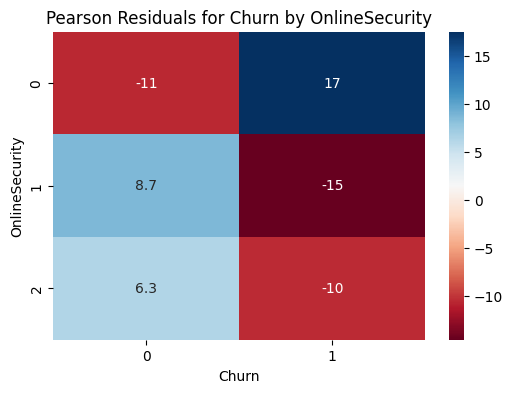

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_sec, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("OnlineSecurity")
plt.title("Pearson Residuals for Churn by OnlineSecurity")
plt.show()

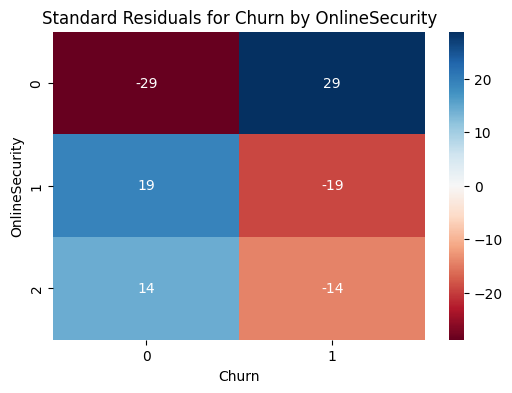

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_res_sec, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("OnlineSecurity")
plt.title("Standard Residuals for Churn by OnlineSecurity")
plt.show()

### 95% CI Wilson CI

In [ ]:
ct_sec['Churn rate'] = ct_sec['Yes'] / ct_sec['All']
ct_sec

Churn,No,Yes,All,Churn rate
OnlineSecurity,,,,
No,2037,1461,3498,0.417667
No internet service,1413,113,1526,0.074050
Yes,1724,295,2019,0.146112
All,5174,1869,7043,0.265370


In [ ]:

CI_sec = ct_sec.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                    axis=1)

ct_sec['CI Low'] = [c[0] for c in CI_sec]
ct_sec['CI High'] = [c[1] for c in CI_sec]

ct_sec

Churn,No,Yes,All,Churn rate,CI Low,CI High
OnlineSecurity,,,,,,
No,2037,1461,3498,0.417667,0.401423,0.434092
No internet service,1413,113,1526,0.074050,0.061954,0.088284
Yes,1724,295,2019,0.146112,0.131377,0.162191
All,5174,1869,7043,0.265370,0.255188,0.275807


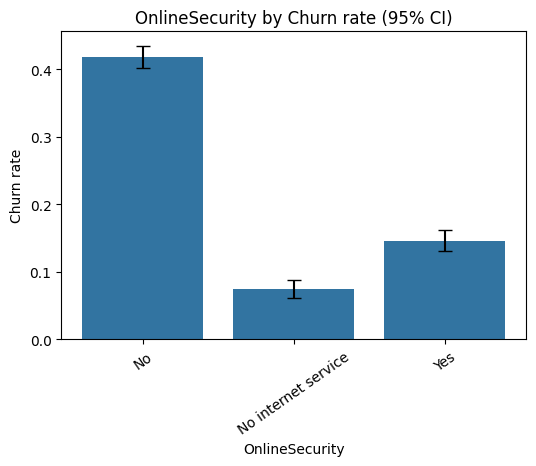

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_sec[:-1].index, y=ct_sec['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_sec[:-1])), y=ct_sec['Churn rate'][:-1],
             yerr=[ct_sec['Churn rate'][:-1] - ct_sec['CI Low'][:-1], ct_sec['CI High'][:-1] - ct_sec['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.xticks(rotation=35)
plt.title("OnlineSecurity by Churn rate (95% CI)")
plt.show()

### OddsRatio

In [ ]:
obs_sec

array([[2037, 1461],
       [1413,  113],
       [1724,  295]])

In [ ]:
yes_vs_no_sec = np.vstack([obs_sec[0], obs_sec[2]])
yes_vs_noint_sec = np.vstack([obs_sec[1], obs_sec[2]])

In [ ]:
table_yn_sec = sm.stats.Table2x2(yes_vs_no_sec)
odds_ratio_yn_sec = table_yn_sec.oddsratio
odds_ratio_yn_ci_sec =table_yn_sec.oddsratio_confint()

print("OddsRatio for Yes and No OnlineSecurity:", odds_ratio_yn_sec)
print("95% CI:", odds_ratio_yn_ci_sec)


OddsRatio for Yes and No OnlineSecurity: 0.2385753488615845
95% CI: (np.float64(0.20728529636688026), np.float64(0.2745886856522885))


In [ ]:
table_yint_sec = sm.stats.Table2x2(yes_vs_noint_sec)
odds_ratio_yint_sec = table_yint_sec.oddsratio
odds_ratio_yint_ci_sec =table_yint_sec.oddsratio_confint()

print("OddsRatio for Yes and NoInternetService OnlineSecurity:", odds_ratio_yint_sec)
print("95% CI:", odds_ratio_yint_ci_sec)


OddsRatio for Yes and NoInternetService OnlineSecurity: 2.13967825390633
95% CI: (np.float64(1.7035245475243812), np.float64(2.687500474761502))


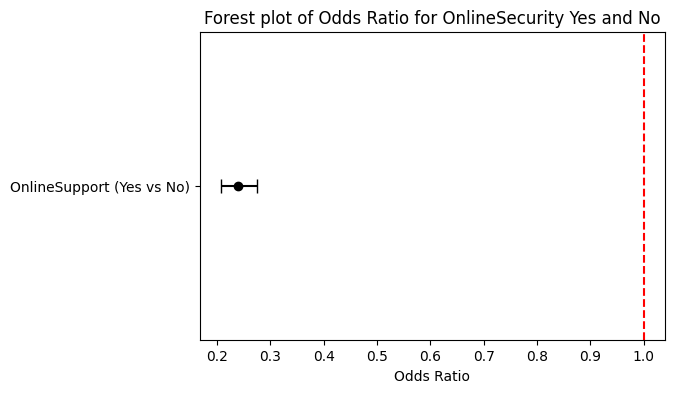

In [ ]:
features = ['OnlineSupport (Yes vs No)']
ci_low_tech = odds_ratio_yn_ci_sec[0]
ci_high_tech = odds_ratio_yn_ci_sec[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_yn_sec], features,
            xerr=[[odds_ratio_yn_sec - ci_low_tech], [ci_high_tech- odds_ratio_yn_sec]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for OnlineSecurity Yes and No")

plt.show()

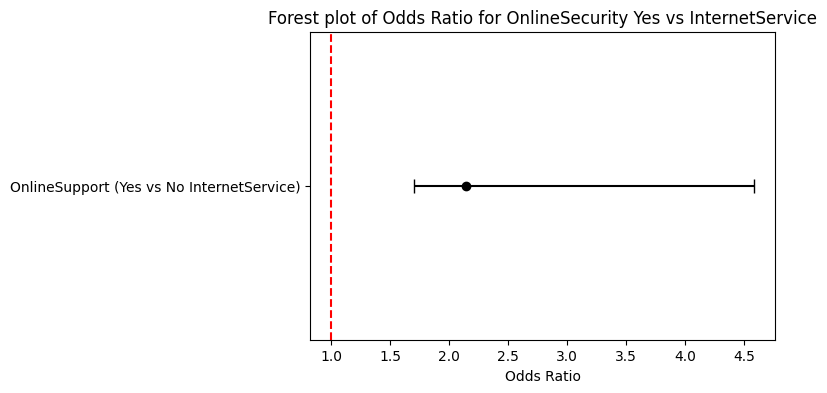

In [ ]:
features = ['OnlineSupport (Yes vs No InternetService)']
ci_low_tech = odds_ratio_yint_ci_sec[0]
ci_high_tech = odds_ratio_yint_ci_sec[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_yint_sec], features,
            xerr=[[odds_ratio_yint_sec - ci_low_tech], [ci_high_tech- odds_ratio_yn_sec]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for OnlineSecurity Yes vs InternetService")

plt.show()

The OnlineSupport shows very similar features compared to techSupport. The cramer's V is almost equal. The Standrad Residuals and Pearson Residuals also showing the similarity. When checking upon OddsRatio, 76% more less likely churners for people with Onlinesecurity than without. The group without internetservice is less likely to churn as with group yes it is 2.4 times more churners.

The similarity at oddsRatio, ie, the artificiality in Nointernet service group is similar in both. The TechSupport, onlinesecurity comes with the internetservice. So the people choose without internet service is less likely due to no internet in these catgeories.

Keeping these features both for tree based model in stage of modelling. For logistic Regression, either droping either or combining.

## Looking on to `OnlineBackup`

In [ ]:
customer_df['OnlineBackup'].unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [ ]:
customer_df['OnlineBackup'].value_counts(normalize=True)

,proportion
OnlineBackup,
No,0.438450
Yes,0.344881
No internet service,0.216669


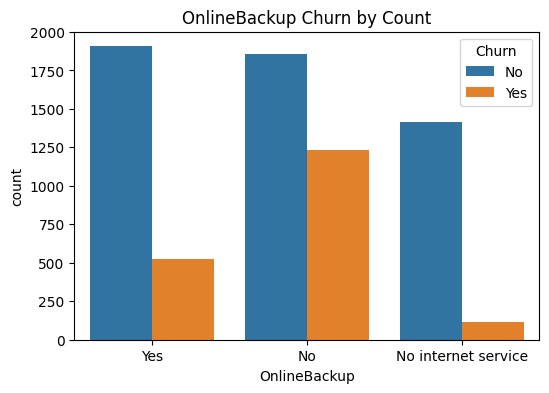

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='OnlineBackup', hue='Churn')
plt.title("OnlineBackup Churn by Count")
plt.show()

In [ ]:
back_rate = customer_df.groupby('OnlineBackup')['Churn'].apply(lambda x: (x=='Yes').mean())
back_rate

,Churn
OnlineBackup,
No,0.399288
No internet service,0.074050
Yes,0.215315


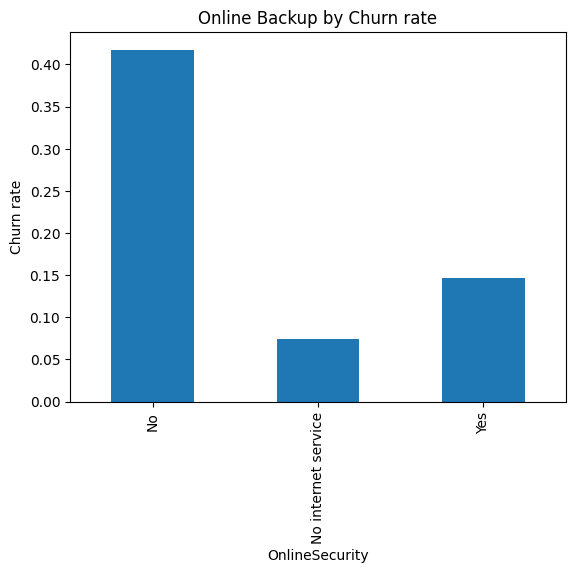

In [ ]:
sec_rate.plot(kind='bar')
plt.title("Online Backup by Churn rate")
plt.ylabel("Churn rate")
plt.show()

### Chi2 test

Null hypotheses H0: The churn and onlineBackup is independent

Alternative hypotheses H1: The Churn and onlineBackup is not independent

In [ ]:
ct_back = pd.crosstab(customer_df['OnlineBackup'], customer_df['Churn'], margins=True)
ct_back

Churn,No,Yes,All
OnlineBackup,,,
No,1855,1233,3088
No internet service,1413,113,1526
Yes,1906,523,2429
All,5174,1869,7043


In [ ]:
chi2_back, p_back, dof_back, expected_back = chi2_contingency(ct_back.iloc[:-1, :-1])
print("Chi2 statistics for OnlineBackup:", chi2_back)
print("P Value OnlineBackup:", p_back)
print("Degrees of freedom for OnlineBackup:", dof_back)
print("\nExpected contigency table (if independent) for OnlineBackup:\n", np.round(expected_back, 1))

Chi2 statistics for OnlineBackup: 601.812790113409
P Value OnlineBackup: 2.0797592160864276e-131
Degrees of freedom for OnlineBackup: 2

Expected contigency table (if independent) for OnlineBackup:
 [[2268.5  819.5]
 [1121.   405. ]
 [1784.4  644.6]]


In [ ]:
print("Rejecting null hypothese:", p_back < 0.05)

Rejecting null hypothese: True


In [ ]:
obs_back = ct_back.iloc[:-1, :-1].to_numpy()
N_back = obs_back.sum()
r_back, c_back = ct_back.iloc[:-1, :-1].shape
back_V = cramers_V(chi2_back, N_back,
                  r_back, c_back)

print("Cramer's V strength of association:", back_V)

Cramer's V strength of association: 0.2923155121954445


### Residuals

In [ ]:
raw_residuals_back = obs_back - expected_back
print("Raw Residuals:\n", raw_residuals_back)

Raw Residuals:
 [[-413.53783899  413.53783899]
 [ 291.95442283 -291.95442283]
 [ 121.58341616 -121.58341616]]


In [ ]:
pearson_back = pearson_res(obs_back, expected_back)
print("Pearson Residuals for OnlineBackup:\n", np.round(pearson_back,1))

Pearson Residuals for OnlineBackup:
 [[ -8.7  14.4]
 [  8.7 -14.5]
 [  2.9  -4.8]]


In [ ]:
row_back = obs_back.sum(axis=1)[:, None]
col_back = obs_back.sum(axis=0)[None, :]

std_res_back = haberman_res(obs_back, expected_back,
                           row_back, col_back, N_back)
print("Standard Residuals for OnlineBackup:\n", np.round(std_res_back,1))

Standard Residuals for OnlineBackup:
 [[-22.5  22.5]
 [ 19.1 -19.1]
 [  6.9  -6.9]]


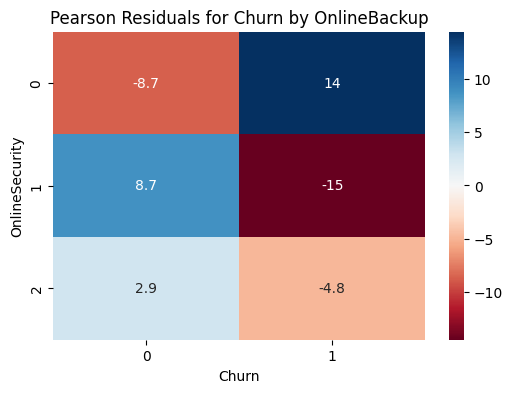

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_back, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("OnlineSecurity")
plt.title("Pearson Residuals for Churn by OnlineBackup")
plt.show()

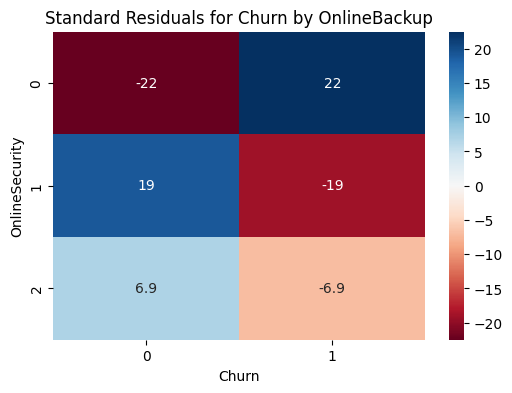

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_res_back, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("OnlineSecurity")
plt.title("Standard Residuals for Churn by OnlineBackup")
plt.show()

### CI wilson 95% CI

In [ ]:
ct_back['Churn rate'] = ct_back['Yes'] / ct_back['All']
ct_back

Churn,No,Yes,All,Churn rate
OnlineBackup,,,,
No,1855,1233,3088,0.399288
No internet service,1413,113,1526,0.074050
Yes,1906,523,2429,0.215315
All,5174,1869,7043,0.265370


In [ ]:
CI_back = ct_back.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                    axis=1)

ct_back['CI Low'] = [c[0] for c in CI_back]
ct_back['CI High'] = [c[1] for c in CI_back]

ct_back

Churn,No,Yes,All,Churn rate,CI Low,CI High
OnlineBackup,,,,,,
No,1855,1233,3088,0.399288,0.382149,0.416676
No internet service,1413,113,1526,0.074050,0.061954,0.088284
Yes,1906,523,2429,0.215315,0.199425,0.232104
All,5174,1869,7043,0.265370,0.255188,0.275807


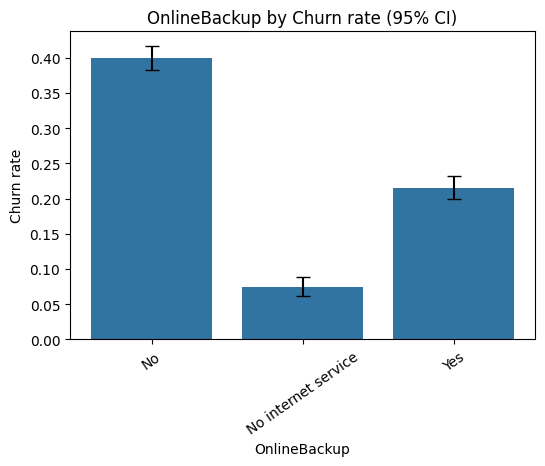

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_back[:-1].index, y=ct_back['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_back[:-1])), y=ct_back['Churn rate'][:-1],
             yerr=[ct_back['Churn rate'][:-1] - ct_back['CI Low'][:-1], ct_back['CI High'][:-1] - ct_back['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.xticks(rotation=35)
plt.title("OnlineBackup by Churn rate (95% CI)")
plt.show()

In [ ]:
yes_vs_no_back = np.vstack([obs_back[0], obs_back[2]])
yes_vs_noint_back = np.vstack([obs_back[1], obs_back[2]])

In [ ]:
table_yn_back = sm.stats.Table2x2(yes_vs_no_back)
odds_ratio_yn_back = table_yn_back.oddsratio
odds_ratio_yn_ci_back = table_yn_back.oddsratio_confint()

print("OddsRatio for No and Yes:", odds_ratio_yn_back)
print("95% CI:", odds_ratio_yn_ci_back)

OddsRatio for No and Yes: 0.41281895478401326
95% CI: (np.float64(0.36591408714536655), np.float64(0.4657363447208932))


In [ ]:
table_yn_no_back = sm.stats.Table2x2(yes_vs_noint_back)
odds_ratio_yn_no_back = table_yn_no_back.oddsratio
odds_ratio_yn_ci_no_back = table_yn_no_back.oddsratio_confint()

print("OddsRatio for NoInternet and Yes:", odds_ratio_yn_no_back)
print("95% CI:", odds_ratio_yn_ci_no_back)

OddsRatio for NoInternet and Yes: 3.4311721717167027
95% CI: (np.float64(2.7683529478717768), np.float64(4.252688401243707))


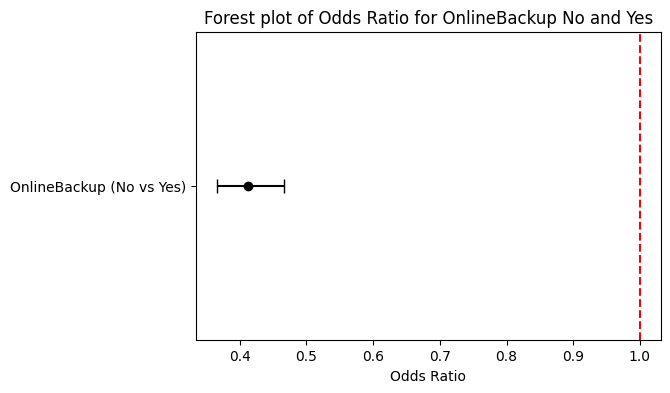

In [ ]:
features = ['OnlineBackup (No vs Yes)']
ci_low_tech = odds_ratio_yn_ci_back[0]
ci_high_tech = odds_ratio_yn_ci_back[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_yn_back], features,
            xerr=[[odds_ratio_yn_back - ci_low_tech], [ci_high_tech- odds_ratio_yn_back]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for OnlineBackup No and Yes")

plt.show()

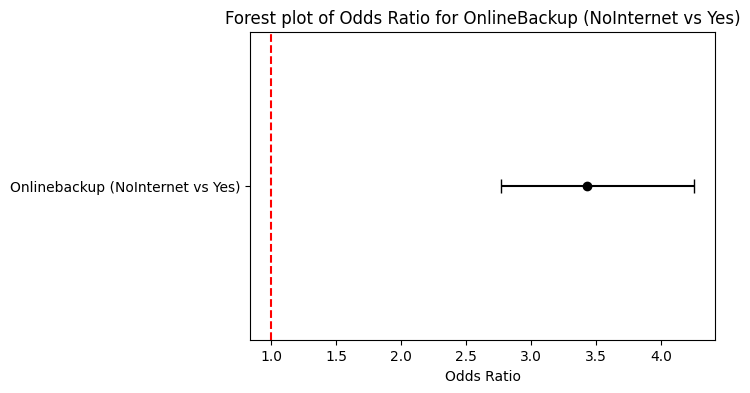

In [ ]:
features = ['Onlinebackup (NoInternet vs Yes)']
ci_low_tech = odds_ratio_yn_ci_no_back[0]
ci_high_tech = odds_ratio_yn_ci_no_back[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_yn_no_back], features,
            xerr=[[odds_ratio_yn_no_back - ci_low_tech], [ci_high_tech- odds_ratio_yn_no_back]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for OnlineBackup (NoInternet vs Yes)")

plt.show()

## Analyzing `DeviceProtection`

In [ ]:
customer_df['DeviceProtection'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
customer_df['DeviceProtection'].value_counts(normalize=True)

,proportion
DeviceProtection,
No,0.439443
Yes,0.343888
No internet service,0.216669


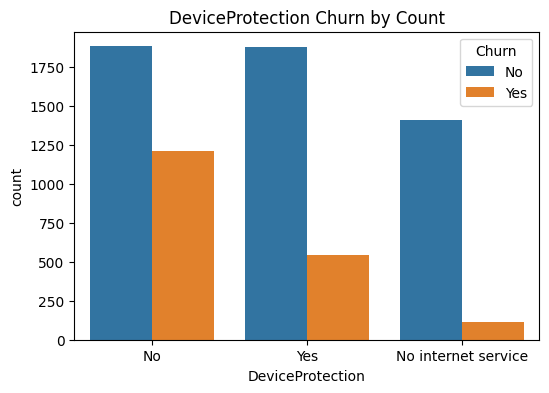

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='DeviceProtection', hue='Churn')
plt.title("DeviceProtection Churn by Count")
plt.show()

In [ ]:
device_rate = customer_df.groupby('DeviceProtection')['Churn'].apply(lambda x: (x=='Yes').mean())
device_rate

,Churn
DeviceProtection,
No,0.391276
No internet service,0.074050
Yes,0.225021


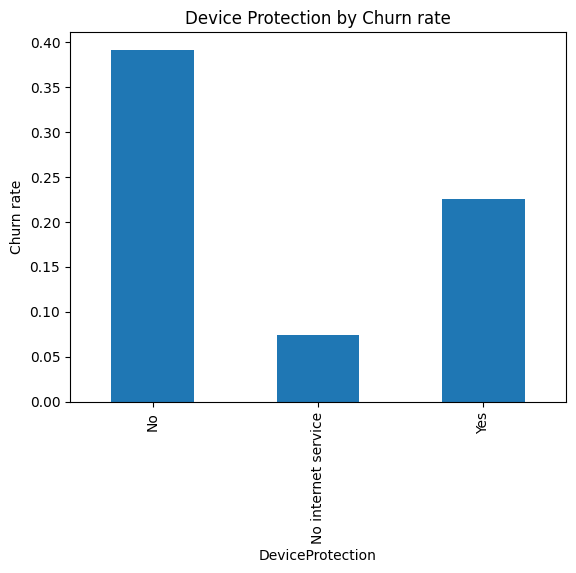

In [ ]:
device_rate.plot(kind='bar')
plt.title("Device Protection by Churn rate")
plt.ylabel("Churn rate")
plt.show()

## Chi2 test
Null hypotheses H0: The churn and DeviceProtection is independent

Alternative hypotheses H1: The Churn and DeviceProtection is not independent

In [ ]:
ct_device = pd.crosstab(customer_df['DeviceProtection'], customer_df['Churn'], margins=True)
ct_device

Churn,No,Yes,All
DeviceProtection,,,
No,1884,1211,3095
No internet service,1413,113,1526
Yes,1877,545,2422
All,5174,1869,7043


In [ ]:
chi2_device, p_device, dof_device, expected_device = chi2_contingency(ct_device.iloc[:-1, :-1])
print("Chi2 statistics for DeviceProtection:", chi2_device)
print("P Value DeviceProtection:", p_device)
print("Degrees of freedom for DeviceProtection:", dof_device)
print("\nExpected contigency table (if independent) for DeviceProtection:\n", np.round(expected_device, 1))

Chi2 statistics for DeviceProtection: 558.419369407389
P Value DeviceProtection: 5.505219496457244e-122
Degrees of freedom for DeviceProtection: 2

Expected contigency table (if independent) for DeviceProtection:
 [[2273.7  821.3]
 [1121.   405. ]
 [1779.3  642.7]]


In [ ]:
print("Rejecting null hypotheses:", p_device < 0.05)

Rejecting null hypotheses: True


In [ ]:
obs_device = ct_device.iloc[:-1, :-1].to_numpy()
N_device = obs_device.sum()
r_device, c_device = obs_device.shape
device_V = cramers_V(chi2_device, N_device,
                  r_device, c_device)

print("Cramer's V strength of association:", device_V)

Cramer's V strength of association: 0.281579732968073


### Residuals

In [ ]:
raw_residuals_device = obs_device - expected_device
print("Raw Residuals:\n", np.round(raw_residuals_device,1))

Raw Residuals:
 [[-389.7  389.7]
 [ 292.  -292. ]
 [  97.7  -97.7]]


In [ ]:
pearson_device = pearson_res(obs_device, expected_device)
print("Pearson Residuals for DeviceProtection:\n", np.round(pearson_device,1))

Pearson Residuals for DeviceProtection:
 [[ -8.2  13.6]
 [  8.7 -14.5]
 [  2.3  -3.9]]


In [ ]:
row_device = obs_device.sum(axis=1)[:, None]
col_device = obs_device.sum(axis=0)[None, :]

std_res_device = haberman_res(obs_device, expected_device,
                           row_device, col_device, N_device)
print("Standard Residuals for DeviceProtection:\n", np.round(std_res_device,1))

Standard Residuals for DeviceProtection:
 [[-21.2  21.2]
 [ 19.1 -19.1]
 [  5.6  -5.6]]


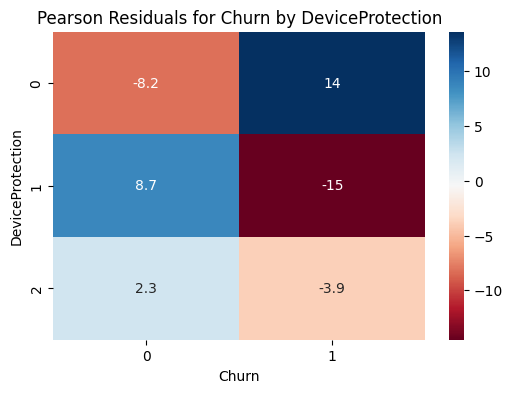

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_device, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("DeviceProtection")
plt.title("Pearson Residuals for Churn by DeviceProtection")
plt.show()

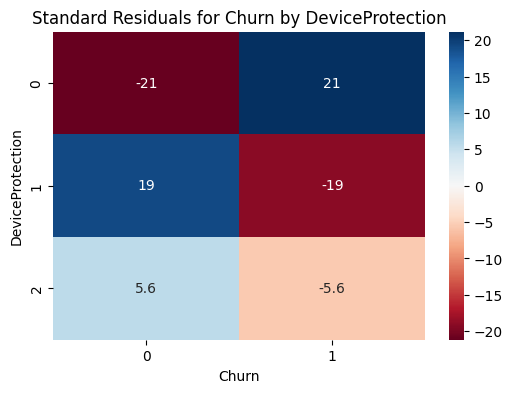

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_res_device, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("DeviceProtection")
plt.title("Standard Residuals for Churn by DeviceProtection")
plt.show()

### Wilson Ci 95% CI

In [ ]:
ct_device['Churn rate'] = ct_device['Yes'] / ct_device['All']
ct_device

Churn,No,Yes,All,Churn rate
DeviceProtection,,,,
No,1884,1211,3095,0.391276
No internet service,1413,113,1526,0.074050
Yes,1877,545,2422,0.225021
All,5174,1869,7043,0.265370


In [ ]:
CI_device = ct_device.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                    axis=1)

ct_device['CI Low'] = [c[0] for c in CI_device]
ct_device['CI High'] = [c[1] for c in CI_device]

ct_device

Churn,No,Yes,All,Churn rate,CI Low,CI High
DeviceProtection,,,,,,
No,1884,1211,3095,0.391276,0.374227,0.408595
No internet service,1413,113,1526,0.074050,0.061954,0.088284
Yes,1877,545,2422,0.225021,0.208833,0.242080
All,5174,1869,7043,0.265370,0.255188,0.275807


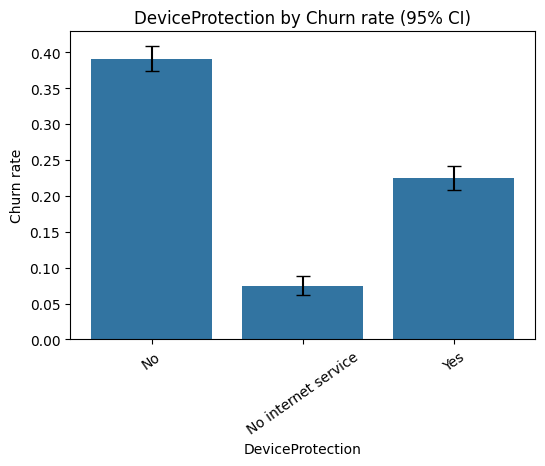

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_device[:-1].index, y=ct_device['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_device[:-1])), y=ct_device['Churn rate'][:-1],
             yerr=[ct_device['Churn rate'][:-1] - ct_device['CI Low'][:-1], ct_device['CI High'][:-1] - ct_device['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.xticks(rotation=35)
plt.title("DeviceProtection by Churn rate (95% CI)")
plt.show()

In [ ]:
yes_vs_no_device = np.vstack([obs_device[0], obs_device[2]])
yes_vs_noint_device = np.vstack([obs_device[1], obs_device[2]])

In [ ]:
table_yn_device = sm.stats.Table2x2(yes_vs_no_device)
odds_ratio_yn_device = table_yn_device.oddsratio
odds_ratio_yn_ci_device = table_yn_device.oddsratio_confint()

print("OddsRatio for No and Yes:", odds_ratio_yn_device)
print("95% CI:", odds_ratio_yn_ci_device)

OddsRatio for No and Yes: 0.4517196520793455
95% CI: (np.float64(0.400796140331578), np.float64(0.5091132961157621))


In [ ]:
table_yint_device = sm.stats.Table2x2(yes_vs_noint_device)
odds_ratio_yint_device = table_yint_device.oddsratio
odds_ratio_yint_ci_device = table_yint_device.oddsratio_confint()

print("OddsRatio for No and Yes:", odds_ratio_yint_device)
print("95% CI:", odds_ratio_yint_ci_device)

OddsRatio for No and Yes: 3.630746672575801
95% CI: (np.float64(2.931188377119753), np.float64(4.49726176021941))


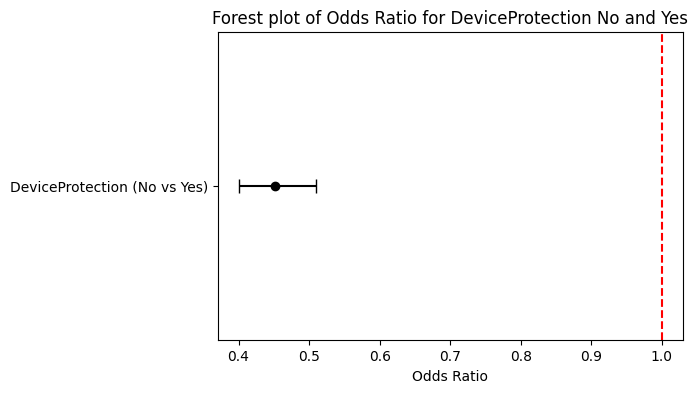

In [ ]:
features = ['DeviceProtection (No vs Yes)']
ci_low_tech = odds_ratio_yn_ci_device[0]
ci_high_tech = odds_ratio_yn_ci_device[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_yn_device], features,
            xerr=[[odds_ratio_yn_device - ci_low_tech], [ci_high_tech- odds_ratio_yn_device]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for DeviceProtection No and Yes")

plt.show()

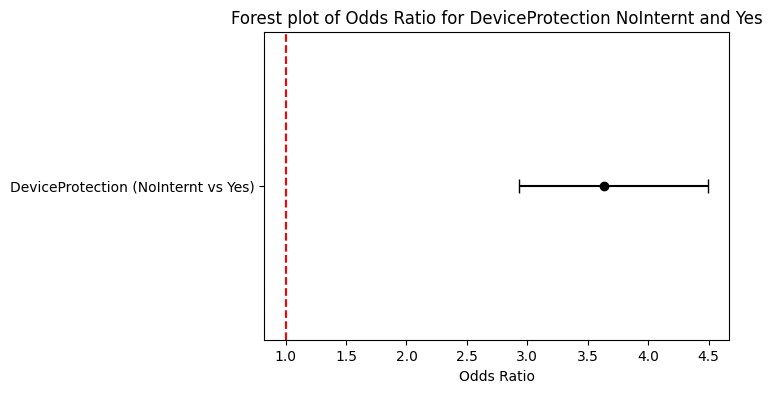

In [ ]:
features = ['DeviceProtection (NoInternt vs Yes)']
ci_low_tech = odds_ratio_yint_ci_device[0]
ci_high_tech = odds_ratio_yint_ci_device[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_yint_device], features,
            xerr=[[odds_ratio_yint_device - ci_low_tech], [ci_high_tech- odds_ratio_yint_device]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for DeviceProtection NoInternt and Yes")

plt.show()

The DeviceProtection estimated to be a predictive feature for churn. From the chi2 test, there is dependency between churn and DeviceProtection. From initial churn rate look ahead, it was clear as there is a similarity between DeviceProtection, TechSupport, OnlineSecurity. In order to confirm that checking Cramer's V for association there was a similarity in association factor. By taking the residuals, there was also a clarification that the group with no deviceprotection has more churners which is similar to the techsupport, OnlineSecurity. The Wilson CI says there is no overlapping in between which seems for the distingushable behaviour. The OddsRatio tells that the Yes group has 55% less likely churners than No group. The group with no internet service is very less likely to churn as they are not internet users and thus no need of deviceprotection.

Insight: From the analysis, the DeviceProtection seem to have a predictive power moderately for churn. But, it seems to be add on service for `internetservice`. There is a correlation between `Techsupport`, `OnlineSecurity`which will disclosing in the future.

In [ ]:
customer_df['PhoneService'].value_counts(normalize=True)

,proportion
PhoneService,
Yes,0.903166
No,0.096834


The `PhoneService` feature having highly imbalanced. Almost 91% users are Yes and only 9% are No. So this will led to bias and may be not a predictive one.
Can add upto Multiplelines or drop it.

## `MultipleLines`

In [ ]:
customer_df['MultipleLines'].value_counts(normalize=True)

,proportion
MultipleLines,
No,0.481329
Yes,0.421837
No phone service,0.096834


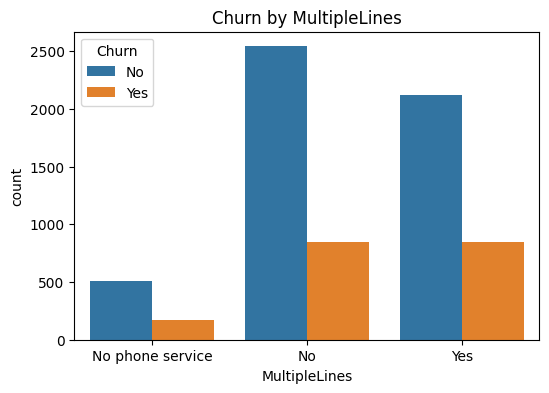

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='MultipleLines', hue='Churn')
plt.title("Churn by MultipleLines")
plt.show()

In [ ]:
ml_rate = customer_df.groupby('MultipleLines')['Churn'].apply(lambda x: (x=='Yes').mean())
ml_rate

,Churn
MultipleLines,
No,0.250442
No phone service,0.249267
Yes,0.286099


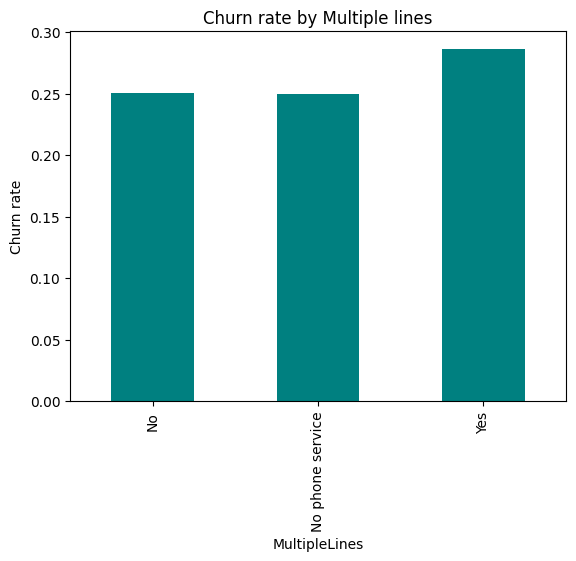

In [ ]:
ml_rate.plot(kind='bar', color='teal')
plt.ylabel("Churn rate")
plt.title("Churn rate by Multiple lines")
plt.show()

### Chi2 test

Null hypotheses h0: The churn and MultipleLine is independent

Alternative hypotheses H1: The both are not independent

In [ ]:
ct_ml = pd.crosstab(customer_df['MultipleLines'], customer_df['Churn'], margins=True)
ct_ml

Churn,No,Yes,All
MultipleLines,,,
No,2541,849,3390
No phone service,512,170,682
Yes,2121,850,2971
All,5174,1869,7043


In [ ]:
chi2_ml, p_ml, dof_ml, expected_ml = chi2_contingency(ct_ml.iloc[:-1, :-1])
print("Chi2 statistics for MultipleLine:", chi2_ml)
print("P value for MultipleLine:", p_ml)
print("Degrees of freedom for MultipleLine:", dof_ml)
print("\nExpected for MultipleLine:\n", np.round(expected_ml,1))

Chi2 statistics for MultipleLine: 11.33044148319756
P value for MultipleLine: 0.0034643829548773
Degrees of freedom for MultipleLine: 2

Expected for MultipleLine:
 [[2490.4  899.6]
 [ 501.   181. ]
 [2182.6  788.4]]


In [ ]:
print("Rejecting null hypotheses:", p_ml < 0.05)

Rejecting null hypotheses: True


In [ ]:
obs_ml = ct_ml.iloc[:-1, :-1].to_numpy()
N_ml = obs_ml.sum()
r_ml, c_ml = obs_ml.shape

ml_V = cramers_V(chi2_ml, N_ml,
                 r_ml, c_ml)
print("Cramer's V for strength of Multiplelines for Churn:", ml_V)

Cramer's V for strength of Multiplelines for Churn: 0.04010925283378871


### Residuals

In [ ]:
raw_res_ml = obs_ml - expected_ml
raw_res_ml

array([[ 50.60386199, -50.60386199],
       [ 10.98225188, -10.98225188],
       [-61.58611387,  61.58611387]])

In [ ]:
pearson_res_ml = pearson_res(obs_ml, expected_ml)
print("Pearson residuals for MultipleLines:\n", np.round(pearson_res_ml, 1))

Pearson residuals for MultipleLines:
 [[ 1.  -1.7]
 [ 0.5 -0.8]
 [-1.3  2.2]]


In [ ]:
row_total_ml = obs_ml.sum(axis=1)[:, None]
col_total_ml = obs_ml.sum(axis=0)[None, :]
std_res_ml = haberman_res(obs_ml, expected_ml,
                          row_total_ml, col_total_ml, N_ml)
print("Standard residuals for MultipleLines:\n", np.round(std_res_ml, 1))

Standard residuals for MultipleLines:
 [[ 2.7 -2.7]
 [ 1.  -1. ]
 [-3.4  3.4]]


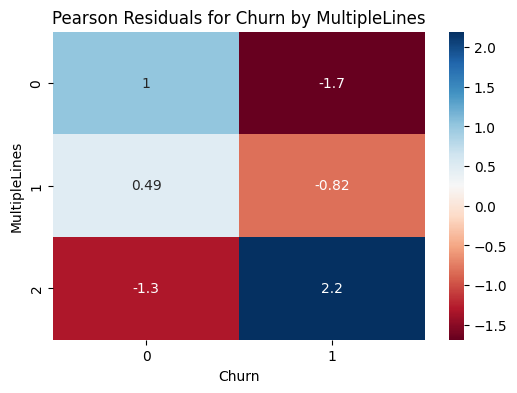

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_res_ml, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("MultipleLines")
plt.title("Pearson Residuals for Churn by MultipleLines")
plt.show()

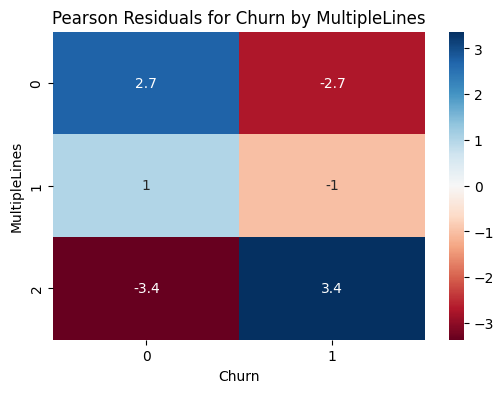

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_res_ml, annot=True, cmap='RdBu')
plt.xlabel("Churn")
plt.ylabel("MultipleLines")
plt.title("Pearson Residuals for Churn by MultipleLines")
plt.show()

### CI wilson 95% CI

In [ ]:
ct_ml['Churn rate'] = ct_ml['Yes'] / ct_ml['All']
ct_ml

Churn,No,Yes,All,Churn rate
MultipleLines,,,,
No,2541,849,3390,0.250442
No phone service,512,170,682,0.249267
Yes,2121,850,2971,0.286099
All,5174,1869,7043,0.265370


In [ ]:
CI_ml = ct_ml.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                    axis=1)

ct_ml['CI Low'] = [c[0] for c in CI_ml]
ct_ml['CI High'] = [c[1] for c in CI_ml]

ct_ml

Churn,No,Yes,All,Churn rate,CI Low,CI High
MultipleLines,,,,,,
No,2541,849,3390,0.250442,0.236146,0.265304
No phone service,512,170,682,0.249267,0.218266,0.283077
Yes,2121,850,2971,0.286099,0.270133,0.302618
All,5174,1869,7043,0.265370,0.255188,0.275807


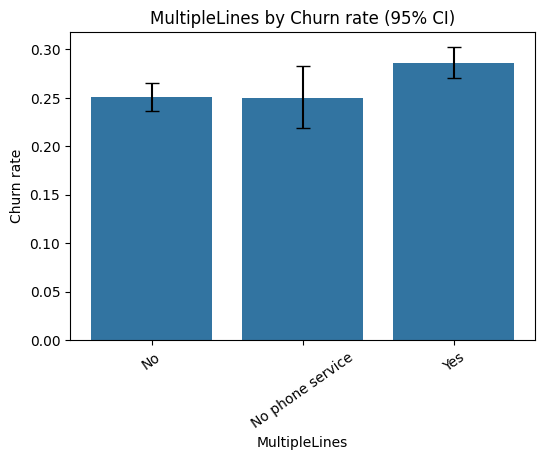

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_ml[:-1].index, y=ct_ml['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_ml[:-1])), y=ct_ml['Churn rate'][:-1],
             yerr=[ct_ml['Churn rate'][:-1] - ct_ml['CI Low'][:-1], ct_ml['CI High'][:-1] - ct_ml['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.xticks(rotation=35)
plt.title("MultipleLines by Churn rate (95% CI)")
plt.show()

### OddsRatio

In [ ]:
ct_ml

Churn,No,Yes,All,Churn rate,CI Low,CI High
MultipleLines,,,,,,
No,2541,849,3390,0.250442,0.236146,0.265304
No phone service,512,170,682,0.249267,0.218266,0.283077
Yes,2121,850,2971,0.286099,0.270133,0.302618
All,5174,1869,7043,0.265370,0.255188,0.275807


In [ ]:
obs_ml[2]

array([2121,  850])

In [ ]:
no_yes_ml = np.vstack([obs_ml[0], obs_ml[2]])
noser_yes_ml = np.vstack([obs_ml[1], obs_ml[2]])

In [ ]:
table_yn_ml = sm.stats.Table2x2(no_yes_ml)
odds_ratio_yn_ml = table_yn_ml.oddsratio
odds_ratio_yn_ci_ml =table_yn_ml.oddsratio_confint()

print("OddsRatio for No and Yes MultipleLines:", odds_ratio_yn_ml)
print("95% CI:", odds_ratio_yn_ci_ml)

OddsRatio for No and Yes MultipleLines: 1.1994308971533196
95% CI: (np.float64(1.073195023370071), np.float64(1.3405154195817877))


In [ ]:
table_ynoser_ml = sm.stats.Table2x2(noser_yes_ml)
odds_ratio_ynoser_ml = table_ynoser_ml.oddsratio
odds_ratio_ynoser_ci_ml =table_ynoser_ml.oddsratio_confint()

print("OddsRatio for No Phone Service and Yes MultipleLines:", odds_ratio_ynoser_ml)
print("95% CI:", odds_ratio_ynoser_ci_ml)


OddsRatio for No Phone Service and Yes MultipleLines: 1.206977840641207
95% CI: (np.float64(0.997256426647856), np.float64(1.460803328884763))


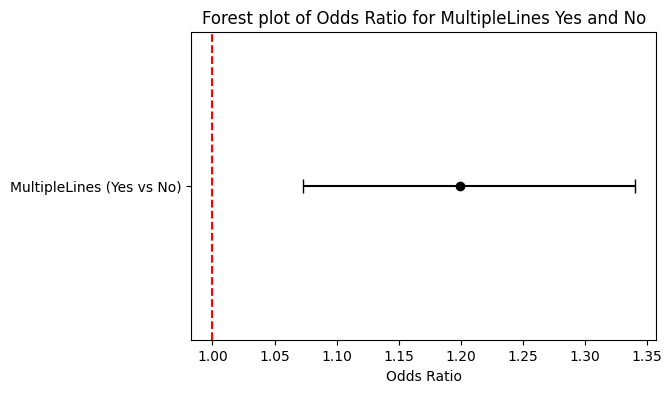

In [ ]:
features = ['MultipleLines (Yes vs No)']
ci_low_tech = odds_ratio_yn_ci_ml[0]
ci_high_tech = odds_ratio_yn_ci_ml[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_yn_ml], features,
            xerr=[[odds_ratio_yn_ml - ci_low_tech], [ci_high_tech- odds_ratio_yn_ml]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for MultipleLines Yes and No")

plt.show()

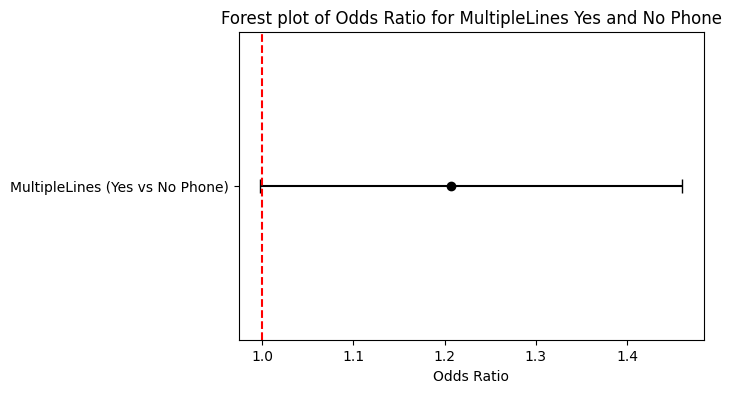

In [ ]:
features = ['MultipleLines (Yes vs No Phone)']
ci_low_tech = odds_ratio_ynoser_ci_ml[0]
ci_high_tech = odds_ratio_ynoser_ci_ml[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_ynoser_ml], features,
            xerr=[[odds_ratio_ynoser_ml - ci_low_tech], [ci_high_tech- odds_ratio_ynoser_ml]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for MultipleLines Yes and No Phone")

plt.show()

The MultipleLines feature is estimated for whether a positive or negative. When looking into its distribution of category there is nothing significant effect to prove it. In order to check the effect, took chi square. The null hypotheses was rejected slightly indicates a smaller narrow depedency for churn. But Cramers'V strength was just 0.04 indicates a weak predictor. The Nophone service is most less churn, while No has slight above residual which indicates less churn than Yes. The residuals clearly indicated that. Wilson Ci for 95% CI there saw the case of overlapping. The three categories were overlapped which indicstes there is no distinguish between these. Odds Ratio tells that the Yes group has more churn than No with Yes as baseline and in No Phone Service and Yes, Yes has still more churners, but CI for No phone Service and Yes was going down 1 even the OR is greater than 1. So it indicates a no statstical significance.

Insigts: `MultipleLines` is a weak predictor. But still keeping it for geature engineering and modelling.

In [ ]:
customer_df['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
customer_df['PaperlessBilling'].value_counts(normalize=True)

,proportion
PaperlessBilling,
Yes,0.592219
No,0.407781


In [ ]:
customer_df['PaymentMethod'].head()

,PaymentMethod
0,Electronic check
1,Mailed check
2,Mailed check
3,Bank transfer (automatic)
4,Electronic check


In [ ]:
customer_df[(customer_df['PaperlessBilling']=='Yes') & (customer_df['PaymentMethod']== 'Credit card (automatic)')].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
23,3638-WEABW,Female,0,Yes,No,58,Yes,Yes,DSL,No,Yes,No,Yes,No,No,Two year,Yes,Credit card (automatic),59.90,3505.1,No
28,5248-YGIJN,Male,0,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),90.25,6369.45,No
30,3841-NFECX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),96.35,6766.95,No
31,4929-XIHVW,Male,1,Yes,No,2,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),95.50,181.65,No


In [ ]:
pd.crosstab(customer_df['PaperlessBilling'], customer_df['Churn'], normalize='index')

Churn,No,Yes
PaperlessBilling,,
No,0.836699,0.163301
Yes,0.664349,0.335651


In [ ]:
pd.crosstab(customer_df['PaymentMethod'], customer_df['Churn'], normalize='index')

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067


In [ ]:
ct_paper = pd.crosstab(customer_df['PaperlessBilling'], customer_df['PaymentMethod'])
ct_paper

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
PaperlessBilling,,,,
No,653,640,623,956
Yes,891,882,1742,656


### Chi2 test for PaperlessBilling and PaymentMethod

In [ ]:
chi2_paper, p_paper, dof_paper, expected_paper = chi2_contingency(ct_paper)
print("Chi2 statistics:", chi2_paper)
print("P value:", p_paper)
print("Degrees of freedom:", dof_paper)
print("\nExpected (if independent):\n", expected_paper)

Chi2 statistics: 435.6865186647808
P value: 4.115239070710319e-94
Degrees of freedom: 3

Expected (if independent):
 [[ 629.61351697  620.64233991  964.40153344  657.34260968]
 [ 914.38648303  901.35766009 1400.59846656  954.65739032]]


In [ ]:
print("Rejecting the PaperlessBilling and PaymentMethod is independent:", p_paper < 0.05)

Rejecting the PaperlessBilling and PaymentMethod is independent: True


In [ ]:
customer_df.groupby(['PaymentMethod', 'PaperlessBilling'])['Churn'].apply(lambda x: (x=='Yes').mean())

PaymentMethod              PaperlessBilling
Bank transfer (automatic)  No                  0.110260
                           Yes                 0.208754
Credit card (automatic)    No                  0.100000
                           Yes                 0.190476
Electronic check           No                  0.327448
                           Yes                 0.497704
Mailed check               No                  0.134937
                           Yes                 0.272866
Name: Churn, dtype: float64

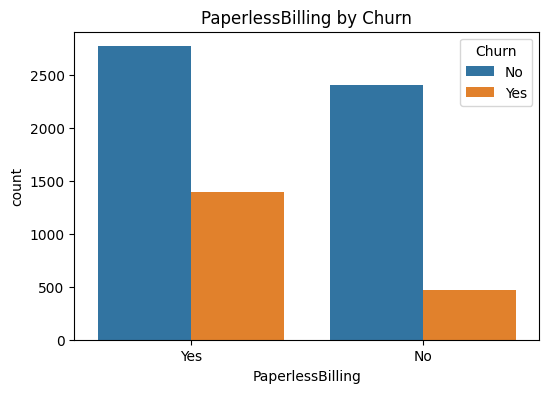

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='PaperlessBilling', hue='Churn')
plt.title("PaperlessBilling by Churn")
plt.show()

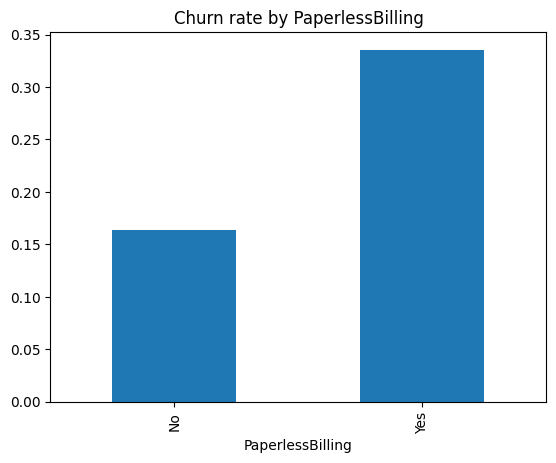

In [ ]:
paper_rate = customer_df.groupby('PaperlessBilling')['Churn'].apply(lambda x: (x=='Yes').mean())
paper_rate.plot(kind='bar')
plt.title("Churn rate by PaperlessBilling")
plt.show()

### chi2 test for Churn ad PaperlessBilling

Null hypotheses H0: The Churn and PaperlessBilling are independent

Alternative hypotheses H1: The Churn and PaperlessBilling are not independent

In [ ]:
ct_paper = pd.crosstab(customer_df['PaperlessBilling'], customer_df['Churn'], margins=True)
ct_paper

Churn,No,Yes,All
PaperlessBilling,,,
No,2403,469,2872
Yes,2771,1400,4171
All,5174,1869,7043


In [ ]:
chi2_pap, p_pap, dof_pap, expected_pap = chi2_contingency(ct_paper.iloc[:-1, :-1])
print("Chi2 statistics:", chi2_pap)
print("P value:", p_pap)
print("Degrees of freedom:", dof_pap)
print("\nExpected contigency table (if independent):\n", expected_pap)

Chi2 statistics: 258.27764906707307
P value: 4.073354668665985e-58
Degrees of freedom: 1

Expected contigency table (if independent):
 [[2109.85773108  762.14226892]
 [3064.14226892 1106.85773108]]


In [ ]:
obs_pap = ct_paper.iloc[:-1, :-1].to_numpy()
N_pap = obs_pap.sum()
r_pap, c_pap = obs_pap.shape

paper_V = cramers_V(chi2_pap, N_pap,
                    r_pap, c_pap)

phi_pap = np.sqrt(chi2_pap / N_pap)

print("Phi test for association or strength:", phi_pap)

Phi test for association or strength: 0.19149814355338285


### Residuals

In [ ]:
raw_res_pap = obs_pap - expected_pap
print("Raw residuals:\n", raw_res_pap)

Raw residuals:
 [[ 293.14226892 -293.14226892]
 [-293.14226892  293.14226892]]


In [ ]:
pearson_res_pap = pearson_res(obs_pap, expected_pap)
print("Pearson Residuals:\n", np.round(pearson_res_pap,1))

Pearson Residuals:
 [[  6.4 -10.6]
 [ -5.3   8.8]]


In [ ]:
row_tot_pap = obs_pap.sum(axis=1)
col_tot_pap = obs_pap.sum(axis=0)

std_res_pap = haberman_res(obs_pap, expected_pap,
                           row_tot_pap, col_tot_pap,
                           N_pap)
print("Standard Residuals:\n", np.round(std_res_pap,1))

Standard Residuals:
 [[ 16.1 -19.4]
 [-13.4  16.1]]


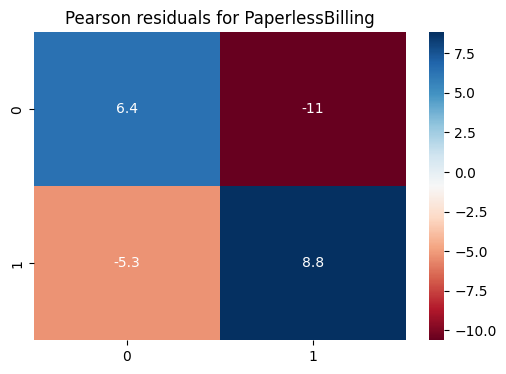

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_res_pap, annot=True, cmap='RdBu')
plt.title("Pearson residuals for PaperlessBilling")
plt.show()

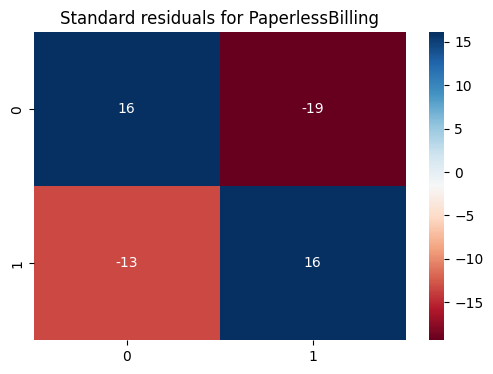

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_res_pap, annot=True, cmap='RdBu')
plt.title("Standard residuals for PaperlessBilling")
plt.show()

###  CI Wilson 95% CI

In [ ]:
ct_paper['Churn rate'] = ct_paper['Yes'] / ct_paper['All']
ct_paper

Churn,No,Yes,All,Churn rate
PaperlessBilling,,,,
No,2403,469,2872,0.163301
Yes,2771,1400,4171,0.335651
All,5174,1869,7043,0.265370


In [ ]:
CI_paper = ct_paper.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                    axis=1)

ct_paper['CI Low'] = [c[0] for c in CI_paper]
ct_paper['CI High'] = [c[1] for c in CI_paper]

ct_paper

Churn,No,Yes,All,Churn rate,CI Low,CI High
PaperlessBilling,,,,,,
No,2403,469,2872,0.163301,0.150233,0.177268
Yes,2771,1400,4171,0.335651,0.321477,0.350127
All,5174,1869,7043,0.265370,0.255188,0.275807


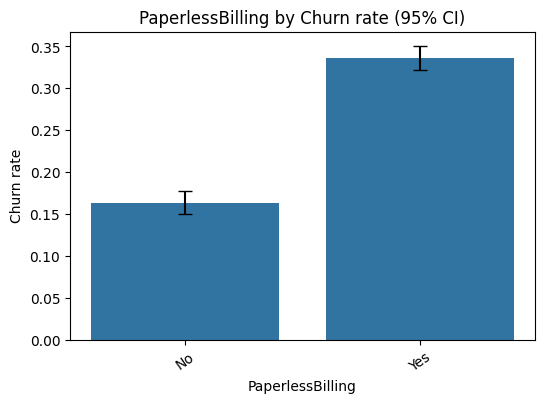

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_paper[:-1].index, y=ct_paper['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_paper[:-1])), y=ct_paper['Churn rate'][:-1],
             yerr=[ct_paper['Churn rate'][:-1] - ct_paper['CI Low'][:-1], ct_paper['CI High'][:-1] - ct_paper['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.xticks(rotation=35)
plt.title("PaperlessBilling by Churn rate (95% CI)")
plt.show()

### OddsRatio

In [ ]:
obs_pap

array([[2403,  469],
       [2771, 1400]])

In [ ]:
table_pap = sm.stats.Table2x2(obs_pap)
pap_oddsR = table_pap.oddsratio
pap_oddsR_confint = table_pap.oddsratio_confint()

print("Odds Ratio for PaperlessBilling and Churn:", pap_oddsR)
print("Odds Ratio Confidence Interval for PaperlessBilling and Churn:", pap_oddsR_confint)

Odds Ratio for PaperlessBilling and Churn: 2.58864465115778
Odds Ratio Confidence Interval for PaperlessBilling and Churn: (np.float64(2.3005615653840668), np.float64(2.9128023482601617))


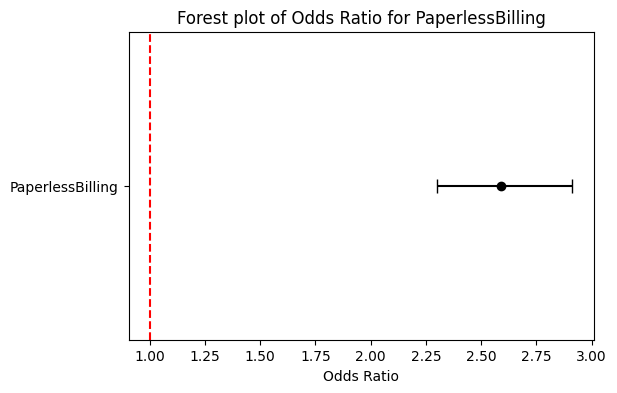

In [ ]:
features = ['PaperlessBilling']
ci_low_tech = pap_oddsR_confint[0]
ci_high_tech = pap_oddsR_confint[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([pap_oddsR], features,
            xerr=[[pap_oddsR - ci_low_tech], [ci_high_tech- pap_oddsR]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for PaperlessBilling")

plt.show()

`PaperlessBilling` estaimates to have a predictive feature for churn. From chi2 test, there is dependency for churn. The Phi test as it is a 2x2 table tells there is moderate association of strength. The Residuals points on the fact that there is more churners on the group with no paperlessBilling. The Wilson CI confirms there is no overlapping and is distinguishable. When taking OddsRatio, the group with paperlessBilling have 2.5 higher churners than without paperlessBilling. When checked with the correlation for `Paperless` and `PaymentMethod`, there is more churners for woth paperless group. Eventhough `Electronic Check` has more churners in paymentmethod, it has Yes group of Paperless for more.

Insight: PaperlessBilling is a moderate predictor for churn. It can be included as a predictive feature. But further checks for correlation is needed for the predictiveness. Users who trusts with paper billing than paperless billing is the sign that got from the analysis.

In [ ]:
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Final Results of Estimation

Predictive features include: `SeniorCitizen`, `Partner`, `Dependents`,	`tenure`, `InternetService`, `OnlineSecurity`, `OnlineBackup`,	`DeviceProtection`,	`TechSupport`, `Contract`,	`PaperlessBilling`,	`PaymentMethod`,	`MonthlyCharge`.

`StreamingTv` and `StreamingMovies` considered highly correlated and may be combined.

`gender` , `Customer Id` has no predictive power and can be avoided and `PhoneService` which have imbalance which will led to bias and thus ignored